## Importing and prepping data

In [1]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca

In [2]:
features = []
remote_folder = 'Gel_Studies/08_14_18_gel_validation' #Folder in AWS S3 containing files to be analyzed
bucket = 'ccurtis.data'
vids = 10
sizes = ['100', '200', '500']
nonnum = ['Particle Size', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity']
featofvar = 'Particle Size'

counter = 0
for size in sizes:
    for num in range(1, vids+1):
        try:
            filename = 'features_{}nm_XY{}.csv'.format(size, '%02d' % num)
            aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name='ccurtis.data')
            fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
            print('{} size: {}'.format(filename, fstats.shape))
            fstats['Particle Size'] = pd.Series(fstats.shape[0]*[size], index=fstats.index)
            fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
            counter = counter + 1
            if counter == 1:
                fstats_tot = fstats
            else:
                fstats_tot = fstats_tot.append(fstats, ignore_index=True)
        except:
            print('skip filename {}'.format(filename))

skip filename features_100nm_XY01.csv
features_100nm_XY02.csv size: (18207, 67)
features_100nm_XY03.csv size: (18178, 67)
features_100nm_XY04.csv size: (20452, 67)
features_100nm_XY05.csv size: (19292, 67)
skip filename features_100nm_XY06.csv
skip filename features_100nm_XY07.csv
skip filename features_100nm_XY08.csv
features_100nm_XY09.csv size: (21766, 67)
skip filename features_100nm_XY10.csv
features_200nm_XY01.csv size: (6072, 67)
features_200nm_XY02.csv size: (6483, 67)
features_200nm_XY03.csv size: (6513, 67)
features_200nm_XY04.csv size: (6412, 67)
features_200nm_XY05.csv size: (5249, 67)
features_200nm_XY06.csv size: (5248, 67)
features_200nm_XY07.csv size: (4674, 67)
features_200nm_XY08.csv size: (5585, 67)
features_200nm_XY09.csv size: (5700, 67)
features_200nm_XY10.csv size: (5198, 67)
features_500nm_XY01.csv size: (5325, 67)
features_500nm_XY02.csv size: (4709, 67)
features_500nm_XY03.csv size: (4125, 67)
features_500nm_XY04.csv size: (1606, 67)
features_500nm_XY05.csv si

In [ ]:
#PCA analyses with too many datapoints fail. You get rows with lots of NAs. I'm going to try making a subset of the data first
#and then do a PCA analysis on that.

#include all in analysis
import random
subset = np.sort(np.array(random.sample(range(fstats_tot.shape[0]), 500000)))
fstats_sub = fstats_tot.loc[subset, :].reset_index(drop=True)

In [4]:
for typ in fstats_tot['Particle Size'].unique():
    fstats_type = fstats_tot[fstats_tot['Particle Size']==typ].reset_index(drop=True)
    print(fstats_type.shape)

(97895, 69)
(57134, 69)
(55041, 69)


In [5]:
#with equal sample sizes for each particle type
import random
counter = 0
for typ in fstats_tot['Particle Size'].unique():
    fstats_type = fstats_tot[fstats_tot['Particle Size']==typ].reset_index(drop=True)
    print(fstats_type.shape)
    subset = np.sort(np.array(random.sample(range(fstats_type.shape[0]), 55000)))
    if counter == 0:
        fstats_sub = fstats_type.loc[subset, :].reset_index(drop=True)
    else:
        fstats_sub = fstats_sub.append(fstats_type.loc[subset, :].reset_index(drop=True), ignore_index=True)
    counter = counter + 1

(97895, 69)
(57134, 69)
(55041, 69)


In [6]:
#fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
fstats_num = fstats_sub.drop(nonnum, axis=1)
fstats_raw = fstats_num.as_matrix()
#fstats

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [8]:
pcadataset = pca.pca_analysis(fstats_tot, dropcols=nonnum, n_components=15)

Cumulative explained variance:
0 component: 0.26456811998350804
1 component: 0.3910484322933804
2 component: 0.4607176185277395
3 component: 0.516093472861476
4 component: 0.5613799711978695
5 component: 0.5941750536673687
6 component: 0.6251942133120792
7 component: 0.6556791619009862
8 component: 0.6838689881887454
9 component: 0.7103888195561195
10 component: 0.7336712357280057
11 component: 0.7544367580800567
12 component: 0.7735633061254458
13 component: 0.7913058624090679
14 component: 0.8070761980081702


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [ ]:
kmostat = pca.kmo(pcadataset.scaled)

In [ ]:
import scipy.stats as stat
stat.bartlett(pcadataset.scaled[0, :], pcadataset.scaled[1, :], pcadataset.scaled[2, :], pcadataset.scaled[3, :])

In [ ]:
newstr = ''
for i in range(pcadataset.scaled.shape[0]-1):
    newstr = newstr + 'pcadataset.scaled[{}, :], '.format(i)

newstr = 'stat.bartlett(' + newstr + 'pcadataset.scaled[{}, :])'.format(i+1)

In [ ]:
test = eval(newstr)

In [ ]:
test

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [ ]:
import numpy as np
ncomp = 14
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pcadataset.final[pcadataset.final['Particle Size']=='100'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pcadataset.final[pcadataset.final['Particle Size']=='200'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pcadataset.final[pcadataset.final['Particle Size']=='500'].values[:, -ncomp:], axis=0)

In [ ]:
pca.plot_pca(dicti, savefig=True, labels=['100nm', '200nm', '500nm'], rticks=np.linspace(-4, 4, 9))

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [ ]:
pcadataset.prcomps

In [ ]:
labels=['100', '200', '500']
feats = pca.feature_violin(pcadataset.final, label='Particle Size', lvals=labels, fsubset=14, yrange=[-12, 12])

In [ ]:
fstats1 = pca.feature_plot_3D(pcadataset.final, label='Particle Size', lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12])

In [ ]:
ncomp = 14
trainp = np.array([])
testp = np.array([])

for i in range(0, 20):
    KNNmod, X, y = pca.build_model(pcadataset.final, 'Particle Size', labels, equal_sampling=True,
                                       tsize=500, input_cols=ncomp, model='MLP', NNhidden_layer=(6, 2))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Particle Size'].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

In [ ]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

In [ ]:
fstats_num

## Neural Network

In [3]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [12]:
ncomp = 15
featofvar = 'Particle Size'
test = pcadataset.final.values[:, -ncomp:]
y = pcadataset.final[featofvar].values
X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.9)

num_trials = 2
model = MLPClassifier(hidden_layer_sizes=(300, ), solver='sgd', verbose=True, max_iter=100, tol=0.001)
scores = np.zeros(num_trials)
gridps = [{'alpha': [0.001, 0.01, 0.5], 'batch_size': [10, 50, 100, 200], 'learning_rate_init': [0.001, 0.005, 0.01]}]

print('# Tuning hyper-parameters for precision')
clf = GridSearchCV(estimator=model, param_grid=gridps, cv=5, scoring='precision_macro')
clf.fit(X_train, y_train)

# Tuning hyper-parameters for precision
Iteration 1, loss = 0.25054738
Iteration 2, loss = 0.18236173
Iteration 3, loss = 0.16504100
Iteration 4, loss = 0.15503288
Iteration 5, loss = 0.14841344
Iteration 6, loss = 0.14321087
Iteration 7, loss = 0.13970694
Iteration 8, loss = 0.13643168
Iteration 9, loss = 0.13311474
Iteration 10, loss = 0.13144194
Iteration 11, loss = 0.12827315
Iteration 12, loss = 0.12654112
Iteration 13, loss = 0.12461385
Iteration 14, loss = 0.12327265
Iteration 15, loss = 0.12191221
Iteration 16, loss = 0.12082347
Iteration 17, loss = 0.11936773
Iteration 18, loss = 0.11757675
Iteration 19, loss = 0.11683063
Iteration 20, loss = 0.11549540
Iteration 21, loss = 0.11472881
Iteration 22, loss = 0.11330495
Iteration 23, loss = 0.11217252
Iteration 24, loss = 0.11104188
Iteration 25, loss = 0.10929297
Iteration 26, loss = 0.10872444
Iteration 27, loss = 0.10784758
Iteration 28, loss = 0.10738449
Training loss did not improve more than tol=0.001000 for two consecutive 

Iteration 5, loss = 0.13944336
Iteration 6, loss = 0.13536899
Iteration 7, loss = 0.13241964
Iteration 8, loss = 0.12939042
Iteration 9, loss = 0.12580249
Iteration 10, loss = 0.12443062
Iteration 11, loss = 0.12247168
Iteration 12, loss = 0.12064826
Iteration 13, loss = 0.11923097
Iteration 14, loss = 0.11776167
Iteration 15, loss = 0.11606307
Iteration 16, loss = 0.11411704
Iteration 17, loss = 0.11269806
Iteration 18, loss = 0.11018172
Iteration 19, loss = 0.10784147
Iteration 20, loss = 0.10820775
Iteration 21, loss = 0.10553736
Iteration 22, loss = 0.10396691
Iteration 23, loss = 0.10419894
Iteration 24, loss = 0.10314862
Iteration 25, loss = 0.09998507
Iteration 26, loss = 0.10184477
Iteration 27, loss = 0.09864337
Iteration 28, loss = 0.09870547
Iteration 29, loss = 0.09581197
Iteration 30, loss = 0.09412246
Iteration 31, loss = 0.09669805
Iteration 32, loss = 0.09466465
Iteration 33, loss = 0.09654565
Training loss did not improve more than tol=0.001000 for two consecutive epoc

Iteration 16, loss = 0.15280372
Iteration 17, loss = 0.15073838
Iteration 18, loss = 0.14873853
Iteration 19, loss = 0.14725079
Iteration 20, loss = 0.14567698
Iteration 21, loss = 0.14421754
Iteration 22, loss = 0.14285180
Iteration 23, loss = 0.14148313
Iteration 24, loss = 0.14024714
Iteration 25, loss = 0.13889672
Iteration 26, loss = 0.13817828
Iteration 27, loss = 0.13703391
Iteration 28, loss = 0.13633068
Iteration 29, loss = 0.13510597
Iteration 30, loss = 0.13398805
Iteration 31, loss = 0.13306014
Iteration 32, loss = 0.13243624
Iteration 33, loss = 0.13164675
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.36609016
Iteration 2, loss = 0.24986886
Iteration 3, loss = 0.22435209
Iteration 4, loss = 0.20949986
Iteration 5, loss = 0.19891032
Iteration 6, loss = 0.19090286
Iteration 7, loss = 0.18444138
Iteration 8, loss = 0.17928359
Iteration 9, loss = 0.17468068
Iteration 10, loss = 0.17065730
Iteration 11, loss = 0

Iteration 1, loss = 0.26191126
Iteration 2, loss = 0.18393519
Iteration 3, loss = 0.16651969
Iteration 4, loss = 0.15619565
Iteration 5, loss = 0.14921579
Iteration 6, loss = 0.14491918
Iteration 7, loss = 0.14024210
Iteration 8, loss = 0.13637587
Iteration 9, loss = 0.13272773
Iteration 10, loss = 0.13045855
Iteration 11, loss = 0.12852012
Iteration 12, loss = 0.12558858
Iteration 13, loss = 0.12402452
Iteration 14, loss = 0.12177813
Iteration 15, loss = 0.11952543
Iteration 16, loss = 0.11873914
Iteration 17, loss = 0.11668980
Iteration 18, loss = 0.11565666
Iteration 19, loss = 0.11433375
Iteration 20, loss = 0.11154202
Iteration 21, loss = 0.11273792
Iteration 22, loss = 0.10928185
Iteration 23, loss = 0.10848260
Iteration 24, loss = 0.10910280
Iteration 25, loss = 0.10578949
Iteration 26, loss = 0.10536928
Iteration 27, loss = 0.10336957
Iteration 28, loss = 0.10234112
Iteration 29, loss = 0.10194729
Iteration 30, loss = 0.10107773
Iteration 31, loss = 0.09906916
Iteration 32, los

Iteration 52, loss = 0.06414961
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.22920103
Iteration 2, loss = 0.17060587
Iteration 3, loss = 0.15614342
Iteration 4, loss = 0.14569188
Iteration 5, loss = 0.14061978
Iteration 6, loss = 0.13635350
Iteration 7, loss = 0.13300708
Iteration 8, loss = 0.12793497
Iteration 9, loss = 0.12567535
Iteration 10, loss = 0.12230200
Iteration 11, loss = 0.11888299
Iteration 12, loss = 0.11943133
Iteration 13, loss = 0.11520628
Iteration 14, loss = 0.11522017
Iteration 15, loss = 0.11147925
Iteration 16, loss = 0.11165016
Iteration 17, loss = 0.10902872
Iteration 18, loss = 0.10401608
Iteration 19, loss = 0.10576214
Iteration 20, loss = 0.10273472
Iteration 21, loss = 0.10134641
Iteration 22, loss = 0.10117323
Iteration 23, loss = 0.09946899
Iteration 24, loss = 0.09517527
Iteration 25, loss = 0.09689806
Iteration 26, loss = 0.09399868
Iteration 27, loss = 0.09399974
Iteration 28, loss = 0

Iteration 5, loss = 0.22445037
Iteration 6, loss = 0.21601614
Iteration 7, loss = 0.20906563
Iteration 8, loss = 0.20320654
Iteration 9, loss = 0.19843426
Iteration 10, loss = 0.19432774
Iteration 11, loss = 0.19062772
Iteration 12, loss = 0.18718134
Iteration 13, loss = 0.18413118
Iteration 14, loss = 0.18130638
Iteration 15, loss = 0.17894362
Iteration 16, loss = 0.17654102
Iteration 17, loss = 0.17451097
Iteration 18, loss = 0.17233045
Iteration 19, loss = 0.17037301
Iteration 20, loss = 0.16877366
Iteration 21, loss = 0.16724926
Iteration 22, loss = 0.16557920
Iteration 23, loss = 0.16439825
Iteration 24, loss = 0.16279768
Iteration 25, loss = 0.16154591
Iteration 26, loss = 0.16043675
Iteration 27, loss = 0.15922481
Iteration 28, loss = 0.15779540
Iteration 29, loss = 0.15688325
Iteration 30, loss = 0.15559583
Iteration 31, loss = 0.15463485
Iteration 32, loss = 0.15360526
Iteration 33, loss = 0.15282598
Iteration 34, loss = 0.15165031
Iteration 35, loss = 0.15095751
Iteration 36,

Iteration 3, loss = 0.16466074
Iteration 4, loss = 0.15477439
Iteration 5, loss = 0.14712892
Iteration 6, loss = 0.14165965
Iteration 7, loss = 0.13682059
Iteration 8, loss = 0.13447323
Iteration 9, loss = 0.12982637
Iteration 10, loss = 0.12813931
Iteration 11, loss = 0.12591232
Iteration 12, loss = 0.12341964
Iteration 13, loss = 0.12197355
Iteration 14, loss = 0.12001041
Iteration 15, loss = 0.11807766
Iteration 16, loss = 0.11923167
Iteration 17, loss = 0.11489237
Iteration 18, loss = 0.11426404
Iteration 19, loss = 0.11221951
Iteration 20, loss = 0.11231641
Iteration 21, loss = 0.10896754
Iteration 22, loss = 0.10962992
Iteration 23, loss = 0.10717302
Iteration 24, loss = 0.10758015
Iteration 25, loss = 0.10838634
Iteration 26, loss = 0.10597275
Iteration 27, loss = 0.10740557
Iteration 28, loss = 0.10247768
Iteration 29, loss = 0.10112693
Iteration 30, loss = 0.09938739
Iteration 31, loss = 0.09676407
Iteration 32, loss = 0.09667989
Iteration 33, loss = 0.09491963
Iteration 34, l

Iteration 5, loss = 0.25463414
Iteration 6, loss = 0.24411888
Iteration 7, loss = 0.23574311
Iteration 8, loss = 0.22864107
Iteration 9, loss = 0.22267359
Iteration 10, loss = 0.21756984
Iteration 11, loss = 0.21308599
Iteration 12, loss = 0.20915102
Iteration 13, loss = 0.20564412
Iteration 14, loss = 0.20242099
Iteration 15, loss = 0.19960553
Iteration 16, loss = 0.19698924
Iteration 17, loss = 0.19460881
Iteration 18, loss = 0.19242954
Iteration 19, loss = 0.19057649
Iteration 20, loss = 0.18861747
Iteration 21, loss = 0.18662626
Iteration 22, loss = 0.18494434
Iteration 23, loss = 0.18328237
Iteration 24, loss = 0.18179606
Iteration 25, loss = 0.18034025
Iteration 26, loss = 0.17896630
Iteration 27, loss = 0.17746597
Iteration 28, loss = 0.17636627
Iteration 29, loss = 0.17513809
Iteration 30, loss = 0.17392398
Iteration 31, loss = 0.17288674
Iteration 32, loss = 0.17171857
Iteration 33, loss = 0.17063169
Iteration 34, loss = 0.16968668
Iteration 35, loss = 0.16922058
Iteration 36,

Iteration 39, loss = 0.12321057
Iteration 40, loss = 0.12076983
Iteration 41, loss = 0.11979447
Iteration 42, loss = 0.11905130
Iteration 43, loss = 0.11893189
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.36245093
Iteration 2, loss = 0.23251704
Iteration 3, loss = 0.20958851
Iteration 4, loss = 0.19556376
Iteration 5, loss = 0.18747372
Iteration 6, loss = 0.18003235
Iteration 7, loss = 0.17313748
Iteration 8, loss = 0.16813853
Iteration 9, loss = 0.16416761
Iteration 10, loss = 0.16073681
Iteration 11, loss = 0.15793880
Iteration 12, loss = 0.15477315
Iteration 13, loss = 0.15247062
Iteration 14, loss = 0.15025939
Iteration 15, loss = 0.14789942
Iteration 16, loss = 0.14568197
Iteration 17, loss = 0.14490369
Iteration 18, loss = 0.14598348
Iteration 19, loss = 0.14043102
Iteration 20, loss = 0.13960568
Iteration 21, loss = 0.13787964
Iteration 22, loss = 0.13676148
Iteration 23, loss = 0.13547771
Iteration 24, loss = 0

Iteration 5, loss = 0.17302907
Iteration 6, loss = 0.16602860
Iteration 7, loss = 0.15997966
Iteration 8, loss = 0.15571333
Iteration 9, loss = 0.15121526
Iteration 10, loss = 0.14712213
Iteration 11, loss = 0.14989501
Iteration 12, loss = 0.14284212
Iteration 13, loss = 0.14109185
Iteration 14, loss = 0.13642254
Iteration 15, loss = 0.13638832
Iteration 16, loss = 0.13276578
Iteration 17, loss = 0.13017731
Iteration 18, loss = 0.12900127
Iteration 19, loss = 0.12757956
Iteration 20, loss = 0.12632641
Iteration 21, loss = 0.12547594
Iteration 22, loss = 0.12447095
Iteration 23, loss = 0.12207005
Iteration 24, loss = 0.12177223
Iteration 25, loss = 0.12377356
Iteration 26, loss = 0.12188654
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.31496236
Iteration 2, loss = 0.20306615
Iteration 3, loss = 0.18375045
Iteration 4, loss = 0.17184495
Iteration 5, loss = 0.16389638
Iteration 6, loss = 0.15730774
Iteration 7, loss = 0.15

Iteration 28, loss = 0.13458390
Iteration 29, loss = 0.13367348
Iteration 30, loss = 0.13305817
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.22693049
Iteration 2, loss = 0.17929734
Iteration 3, loss = 0.16810360
Iteration 4, loss = 0.16182591
Iteration 5, loss = 0.15804398
Iteration 6, loss = 0.15647174
Iteration 7, loss = 0.15285886
Iteration 8, loss = 0.15139221
Iteration 9, loss = 0.14848496
Iteration 10, loss = 0.14873737
Iteration 11, loss = 0.14763085
Iteration 12, loss = 0.14595765
Iteration 13, loss = 0.14602866
Iteration 14, loss = 0.14620365
Iteration 15, loss = 0.14449178
Iteration 16, loss = 0.14444609
Iteration 17, loss = 0.14370806
Iteration 18, loss = 0.14327479
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.22353249
Iteration 2, loss = 0.17765821
Iteration 3, loss = 0.16819129
Iteration 4, loss = 0.16067655
Iteration 5, loss = 0.15836876


Iteration 1, loss = 0.37231317
Iteration 2, loss = 0.25317907
Iteration 3, loss = 0.22910181
Iteration 4, loss = 0.21496240
Iteration 5, loss = 0.20509178
Iteration 6, loss = 0.19767724
Iteration 7, loss = 0.19142216
Iteration 8, loss = 0.18652587
Iteration 9, loss = 0.18157344
Iteration 10, loss = 0.17792641
Iteration 11, loss = 0.17464561
Iteration 12, loss = 0.17159344
Iteration 13, loss = 0.16877275
Iteration 14, loss = 0.16619350
Iteration 15, loss = 0.16396493
Iteration 16, loss = 0.16202895
Iteration 17, loss = 0.15982989
Iteration 18, loss = 0.15808094
Iteration 19, loss = 0.15664960
Iteration 20, loss = 0.15495211
Iteration 21, loss = 0.15307927
Iteration 22, loss = 0.15213131
Iteration 23, loss = 0.15092394
Iteration 24, loss = 0.14963798
Iteration 25, loss = 0.14870476
Iteration 26, loss = 0.14718546
Iteration 27, loss = 0.14636497
Iteration 28, loss = 0.14517217
Iteration 29, loss = 0.14429749
Iteration 30, loss = 0.14319540
Iteration 31, loss = 0.14244798
Iteration 32, los

Iteration 18, loss = 0.12121916
Iteration 19, loss = 0.12041675
Iteration 20, loss = 0.11915007
Iteration 21, loss = 0.11718574
Iteration 22, loss = 0.11656881
Iteration 23, loss = 0.11562321
Iteration 24, loss = 0.11349819
Iteration 25, loss = 0.11267465
Iteration 26, loss = 0.11267015
Iteration 27, loss = 0.11158524
Iteration 28, loss = 0.11117361
Iteration 29, loss = 0.10939748
Iteration 30, loss = 0.10859324
Iteration 31, loss = 0.10766611
Iteration 32, loss = 0.10609113
Iteration 33, loss = 0.10647753
Iteration 34, loss = 0.10511816
Iteration 35, loss = 0.10390790
Iteration 36, loss = 0.10301501
Iteration 37, loss = 0.10272422
Iteration 38, loss = 0.10336335
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.25330140
Iteration 2, loss = 0.18492862
Iteration 3, loss = 0.16903591
Iteration 4, loss = 0.15880676
Iteration 5, loss = 0.15235888
Iteration 6, loss = 0.14725544
Iteration 7, loss = 0.14193001
Iteration 8, loss = 

Iteration 35, loss = 0.15185034
Iteration 36, loss = 0.15097153
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.44433403
Iteration 2, loss = 0.28515106
Iteration 3, loss = 0.25661649
Iteration 4, loss = 0.23963529
Iteration 5, loss = 0.22803764
Iteration 6, loss = 0.21939657
Iteration 7, loss = 0.21199811
Iteration 8, loss = 0.20593060
Iteration 9, loss = 0.20089581
Iteration 10, loss = 0.19620825
Iteration 11, loss = 0.19246782
Iteration 12, loss = 0.18915638
Iteration 13, loss = 0.18628965
Iteration 14, loss = 0.18300687
Iteration 15, loss = 0.18040164
Iteration 16, loss = 0.17784659
Iteration 17, loss = 0.17574340
Iteration 18, loss = 0.17358020
Iteration 19, loss = 0.17141328
Iteration 20, loss = 0.16985273
Iteration 21, loss = 0.16792531
Iteration 22, loss = 0.16630489
Iteration 23, loss = 0.16469658
Iteration 24, loss = 0.16342018
Iteration 25, loss = 0.16187613
Iteration 26, loss = 0.16055607
Iteration 27, loss = 0

Iteration 13, loss = 0.13990333
Iteration 14, loss = 0.13788506
Iteration 15, loss = 0.13555525
Iteration 16, loss = 0.13360486
Iteration 17, loss = 0.13242785
Iteration 18, loss = 0.13040718
Iteration 19, loss = 0.12913389
Iteration 20, loss = 0.12687191
Iteration 21, loss = 0.12616126
Iteration 22, loss = 0.12481865
Iteration 23, loss = 0.12331812
Iteration 24, loss = 0.12209317
Iteration 25, loss = 0.12201255
Iteration 26, loss = 0.12096635
Iteration 27, loss = 0.11940747
Iteration 28, loss = 0.11839792
Iteration 29, loss = 0.11806325
Iteration 30, loss = 0.11693449
Iteration 31, loss = 0.11645723
Iteration 32, loss = 0.11501664
Iteration 33, loss = 0.11585335
Iteration 34, loss = 0.11383590
Iteration 35, loss = 0.11306254
Iteration 36, loss = 0.11381413
Iteration 37, loss = 0.11122154
Iteration 38, loss = 0.11115869
Iteration 39, loss = 0.11004712
Iteration 40, loss = 0.11045368
Iteration 41, loss = 0.10893226
Iteration 42, loss = 0.10837371
Iteration 43, loss = 0.10797479
Iteratio

Iteration 37, loss = 0.09621500
Iteration 38, loss = 0.09556181
Iteration 39, loss = 0.09544397
Iteration 40, loss = 0.09418080
Iteration 41, loss = 0.09210575
Iteration 42, loss = 0.09127613
Iteration 43, loss = 0.09026492
Iteration 44, loss = 0.09046900
Iteration 45, loss = 0.08880646
Iteration 46, loss = 0.09012749
Iteration 47, loss = 0.08934286
Iteration 48, loss = 0.08813433
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.26279169
Iteration 2, loss = 0.18813434
Iteration 3, loss = 0.17069284
Iteration 4, loss = 0.16076561
Iteration 5, loss = 0.15481746
Iteration 6, loss = 0.14757907
Iteration 7, loss = 0.14376336
Iteration 8, loss = 0.14084672
Iteration 9, loss = 0.13776847
Iteration 10, loss = 0.13453567
Iteration 11, loss = 0.13239333
Iteration 12, loss = 0.13000401
Iteration 13, loss = 0.12710681
Iteration 14, loss = 0.12702474
Iteration 15, loss = 0.12476408
Iteration 16, loss = 0.12348508
Iteration 17, loss = 0

Iteration 5, loss = 0.25369446
Iteration 6, loss = 0.24407781
Iteration 7, loss = 0.23666311
Iteration 8, loss = 0.23034311
Iteration 9, loss = 0.22507941
Iteration 10, loss = 0.22048350
Iteration 11, loss = 0.21616409
Iteration 12, loss = 0.21248756
Iteration 13, loss = 0.20919057
Iteration 14, loss = 0.20595391
Iteration 15, loss = 0.20323841
Iteration 16, loss = 0.20069837
Iteration 17, loss = 0.19849473
Iteration 18, loss = 0.19606469
Iteration 19, loss = 0.19410981
Iteration 20, loss = 0.19201230
Iteration 21, loss = 0.19028332
Iteration 22, loss = 0.18854630
Iteration 23, loss = 0.18683430
Iteration 24, loss = 0.18542133
Iteration 25, loss = 0.18376532
Iteration 26, loss = 0.18219516
Iteration 27, loss = 0.18099897
Iteration 28, loss = 0.17966754
Iteration 29, loss = 0.17842001
Iteration 30, loss = 0.17721974
Iteration 31, loss = 0.17612748
Iteration 32, loss = 0.17496986
Iteration 33, loss = 0.17383261
Iteration 34, loss = 0.17274371
Iteration 35, loss = 0.17175678
Iteration 36,

Iteration 13, loss = 0.13666872
Iteration 14, loss = 0.13425398
Iteration 15, loss = 0.13553363
Iteration 16, loss = 0.13111073
Iteration 17, loss = 0.12928680
Iteration 18, loss = 0.12969208
Iteration 19, loss = 0.12624933
Iteration 20, loss = 0.12454474
Iteration 21, loss = 0.12360616
Iteration 22, loss = 0.12299662
Iteration 23, loss = 0.12299189
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.31123380
Iteration 2, loss = 0.20903046
Iteration 3, loss = 0.19066966
Iteration 4, loss = 0.17657365
Iteration 5, loss = 0.16960425
Iteration 6, loss = 0.16255155
Iteration 7, loss = 0.15712437
Iteration 8, loss = 0.15283263
Iteration 9, loss = 0.15009111
Iteration 10, loss = 0.14657236
Iteration 11, loss = 0.14423928
Iteration 12, loss = 0.14264512
Iteration 13, loss = 0.14128506
Iteration 14, loss = 0.13716068
Iteration 15, loss = 0.13531336
Iteration 16, loss = 0.13408778
Iteration 17, loss = 0.13318216
Iteration 18, loss = 0

Iteration 1, loss = 0.46433049
Iteration 2, loss = 0.34577215
Iteration 3, loss = 0.33972972
Iteration 4, loss = 0.33920366
Iteration 5, loss = 0.33832262
Iteration 6, loss = 0.33786291
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.46468582
Iteration 2, loss = 0.34318800
Iteration 3, loss = 0.33958341
Iteration 4, loss = 0.33810716
Iteration 5, loss = 0.33693199
Iteration 6, loss = 0.33767976
Iteration 7, loss = 0.33628165
Iteration 8, loss = 0.33801928
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.41658377
Iteration 2, loss = 0.35010455
Iteration 3, loss = 0.34887806
Iteration 4, loss = 0.34596799
Iteration 5, loss = 0.34543308
Iteration 6, loss = 0.34601776
Iteration 7, loss = 0.34610926
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.41241856
Iteration 2, loss = 0.34925184
Iteration 3, l

Iteration 8, loss = 0.32556959
Iteration 9, loss = 0.31689472
Iteration 10, loss = 0.30930223
Iteration 11, loss = 0.30250394
Iteration 12, loss = 0.29623518
Iteration 13, loss = 0.29043791
Iteration 14, loss = 0.28502914
Iteration 15, loss = 0.27996500
Iteration 16, loss = 0.27575850
Iteration 17, loss = 0.27138628
Iteration 18, loss = 0.26742514
Iteration 19, loss = 0.26385286
Iteration 20, loss = 0.26027673
Iteration 21, loss = 0.25698677
Iteration 22, loss = 0.25410209
Iteration 23, loss = 0.25153557
Iteration 24, loss = 0.24884302
Iteration 25, loss = 0.24643649
Iteration 26, loss = 0.24428658
Iteration 27, loss = 0.24201926
Iteration 28, loss = 0.24042507
Iteration 29, loss = 0.23840550
Iteration 30, loss = 0.23667397
Iteration 31, loss = 0.23503519
Iteration 32, loss = 0.23370217
Iteration 33, loss = 0.23211336
Iteration 34, loss = 0.23057368
Iteration 35, loss = 0.22956492
Iteration 36, loss = 0.22835868
Iteration 37, loss = 0.22729095
Iteration 38, loss = 0.22629153
Iteration 

Iteration 31, loss = 0.23517497
Iteration 32, loss = 0.23372447
Iteration 33, loss = 0.23266757
Iteration 34, loss = 0.23116984
Iteration 35, loss = 0.22998497
Iteration 36, loss = 0.22873161
Iteration 37, loss = 0.22767725
Iteration 38, loss = 0.22667867
Iteration 39, loss = 0.22554050
Iteration 40, loss = 0.22445976
Iteration 41, loss = 0.22355277
Iteration 42, loss = 0.22234124
Iteration 43, loss = 0.22137414
Iteration 44, loss = 0.22059586
Iteration 45, loss = 0.21968268
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.55098642
Iteration 2, loss = 0.37187134
Iteration 3, loss = 0.34247556
Iteration 4, loss = 0.32574085
Iteration 5, loss = 0.31420420
Iteration 6, loss = 0.30542999
Iteration 7, loss = 0.29837688
Iteration 8, loss = 0.29248909
Iteration 9, loss = 0.28744726
Iteration 10, loss = 0.28284207
Iteration 11, loss = 0.27885952
Iteration 12, loss = 0.27522884
Iteration 13, loss = 0.27190321
Iteration 14, loss = 0

Iteration 7, loss = 0.23494699
Iteration 8, loss = 0.22834074
Iteration 9, loss = 0.22237132
Iteration 10, loss = 0.21870452
Iteration 11, loss = 0.21492200
Iteration 12, loss = 0.21155775
Iteration 13, loss = 0.20814446
Iteration 14, loss = 0.20537766
Iteration 15, loss = 0.20266841
Iteration 16, loss = 0.20058853
Iteration 17, loss = 0.19826638
Iteration 18, loss = 0.19644260
Iteration 19, loss = 0.19492543
Iteration 20, loss = 0.19329065
Iteration 21, loss = 0.19196829
Iteration 22, loss = 0.19092738
Iteration 23, loss = 0.19036864
Iteration 24, loss = 0.18853376
Iteration 25, loss = 0.18839921
Iteration 26, loss = 0.18649069
Iteration 27, loss = 0.18604480
Iteration 28, loss = 0.18531386
Iteration 29, loss = 0.18501023
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.38844680
Iteration 2, loss = 0.29781767
Iteration 3, loss = 0.27730919
Iteration 4, loss = 0.26371531
Iteration 5, loss = 0.25285006
Iteration 6, loss = 0

Iteration 17, loss = 0.24627485
Iteration 18, loss = 0.24411496
Iteration 19, loss = 0.24192441
Iteration 20, loss = 0.24029166
Iteration 21, loss = 0.23817802
Iteration 22, loss = 0.23641293
Iteration 23, loss = 0.23497948
Iteration 24, loss = 0.23322413
Iteration 25, loss = 0.23160037
Iteration 26, loss = 0.23028931
Iteration 27, loss = 0.22914061
Iteration 28, loss = 0.22788057
Iteration 29, loss = 0.22633546
Iteration 30, loss = 0.22505139
Iteration 31, loss = 0.22398899
Iteration 32, loss = 0.22285616
Iteration 33, loss = 0.22173368
Iteration 34, loss = 0.22062480
Iteration 35, loss = 0.21965072
Iteration 36, loss = 0.21888366
Iteration 37, loss = 0.21770710
Iteration 38, loss = 0.21684766
Iteration 39, loss = 0.21592769
Iteration 40, loss = 0.21496327
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.64249041
Iteration 2, loss = 0.38371154
Iteration 3, loss = 0.34428103
Iteration 4, loss = 0.32352589
Iteration 5, loss

Iteration 21, loss = 0.18590020
Iteration 22, loss = 0.18475414
Iteration 23, loss = 0.18335939
Iteration 24, loss = 0.18322764
Iteration 25, loss = 0.18093880
Iteration 26, loss = 0.17978426
Iteration 27, loss = 0.18089820
Iteration 28, loss = 0.17764629
Iteration 29, loss = 0.17874730
Iteration 30, loss = 0.17534342
Iteration 31, loss = 0.17486427
Iteration 32, loss = 0.17381160
Iteration 33, loss = 0.17308170
Iteration 34, loss = 0.17250193
Iteration 35, loss = 0.17214100
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.41594817
Iteration 2, loss = 0.27837018
Iteration 3, loss = 0.25864042
Iteration 4, loss = 0.24759764
Iteration 5, loss = 0.23789281
Iteration 6, loss = 0.23174023
Iteration 7, loss = 0.22598838
Iteration 8, loss = 0.22097377
Iteration 9, loss = 0.21714847
Iteration 10, loss = 0.21349360
Iteration 11, loss = 0.21000778
Iteration 12, loss = 0.20758922
Iteration 13, loss = 0.20448200
Iteration 14, loss = 0

Iteration 25, loss = 0.16753655
Iteration 26, loss = 0.16573497
Iteration 27, loss = 0.16468444
Iteration 28, loss = 0.16397266
Iteration 29, loss = 0.16333398
Iteration 30, loss = 0.16270498
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.24326187
Iteration 2, loss = 0.17641940
Iteration 3, loss = 0.15983735
Iteration 4, loss = 0.15060919
Iteration 5, loss = 0.14375925
Iteration 6, loss = 0.13893166
Iteration 7, loss = 0.13463911
Iteration 8, loss = 0.13161421
Iteration 9, loss = 0.12847940
Iteration 10, loss = 0.12610832
Iteration 11, loss = 0.12452430
Iteration 12, loss = 0.12167441
Iteration 13, loss = 0.11911791
Iteration 14, loss = 0.11755161
Iteration 15, loss = 0.11532956
Iteration 16, loss = 0.11286041
Iteration 17, loss = 0.11191572
Iteration 18, loss = 0.11090897
Iteration 19, loss = 0.10955336
Iteration 20, loss = 0.10740000
Iteration 21, loss = 0.10678220
Iteration 22, loss = 0.10420515
Iteration 23, loss = 0

GridSearchCV(cv=5, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(300,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.001, validation_fraction=0.1,
       verbose=True, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.001, 0.01, 0.5], 'batch_size': [10, 50, 100, 200], 'learning_rate_init': [0.001, 0.005, 0.01]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision_macro', verbose=0)

In [13]:
print('Best parameters set found in development set:')
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std*2, params))
print()

Best parameters set found in development set:

{'alpha': 0.001, 'batch_size': 50, 'learning_rate_init': 0.005}

Grid scores on development set:

0.942 (+/-0.010) for {'alpha': 0.001, 'batch_size': 10, 'learning_rate_init': 0.001}
0.941 (+/-0.007) for {'alpha': 0.001, 'batch_size': 10, 'learning_rate_init': 0.005}
0.938 (+/-0.016) for {'alpha': 0.001, 'batch_size': 10, 'learning_rate_init': 0.01}
0.930 (+/-0.012) for {'alpha': 0.001, 'batch_size': 50, 'learning_rate_init': 0.001}
0.945 (+/-0.004) for {'alpha': 0.001, 'batch_size': 50, 'learning_rate_init': 0.005}
0.944 (+/-0.011) for {'alpha': 0.001, 'batch_size': 50, 'learning_rate_init': 0.01}
0.923 (+/-0.009) for {'alpha': 0.001, 'batch_size': 100, 'learning_rate_init': 0.001}
0.939 (+/-0.009) for {'alpha': 0.001, 'batch_size': 100, 'learning_rate_init': 0.005}
0.934 (+/-0.042) for {'alpha': 0.001, 'batch_size': 100, 'learning_rate_init': 0.01}
0.913 (+/-0.012) for {'alpha': 0.001, 'batch_size': 200, 'learning_rate_init': 0.001}
0.93

In [14]:
print("Detailed classification report")
print()
print("The model is trained on the full development set")
print("The scores are computed on the full evaluation set")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Detailed classification report

The model is trained on the full development set
The scores are computed on the full evaluation set

             precision    recall  f1-score   support

        100       1.00      1.00      1.00     88119
        200       0.91      0.93      0.92     51480
        500       0.92      0.91      0.91     49464

avg / total       0.96      0.96      0.96    189063




In [15]:
for run in range(3):
    X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.4)

    clf = MLPClassifier(hidden_layer_sizes=(300, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)
    
    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1))
    
    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))

Iteration 1, loss = 0.17733204
Validation score: 0.939230
Iteration 2, loss = 0.13490218
Validation score: 0.945498
Iteration 3, loss = 0.12501898
Validation score: 0.952479
Iteration 4, loss = 0.11759184
Validation score: 0.954859
Iteration 5, loss = 0.11268121
Validation score: 0.953273
Iteration 6, loss = 0.10867934
Validation score: 0.956129
Iteration 7, loss = 0.10451286
Validation score: 0.959381
Iteration 8, loss = 0.10048258
Validation score: 0.957953
Iteration 9, loss = 0.09694705
Validation score: 0.963903
Iteration 10, loss = 0.09342943
Validation score: 0.965887
Iteration 11, loss = 0.09001000
Validation score: 0.966759
Iteration 12, loss = 0.08755734
Validation score: 0.961920
Iteration 13, loss = 0.08472537
Validation score: 0.969298
Iteration 14, loss = 0.08166005
Validation score: 0.967949
Iteration 15, loss = 0.07909393
Validation score: 0.966839
Iteration 16, loss = 0.07673826
Validation score: 0.970964
Iteration 17, loss = 0.07456497
Validation score: 0.969853
Iterat

             precision    recall  f1-score   support

        100       1.00      1.00      1.00     39211
        200       0.95      0.95      0.95     22796
        500       0.95      0.95      0.95     22021

avg / total       0.97      0.97      0.97     84028

Iteration 1, loss = 0.17663294
Validation score: 0.942007
Iteration 2, loss = 0.13589526
Validation score: 0.951924
Iteration 3, loss = 0.12519362
Validation score: 0.953590
Iteration 4, loss = 0.11855656
Validation score: 0.958350
Iteration 5, loss = 0.11291114
Validation score: 0.961206
Iteration 6, loss = 0.10813642
Validation score: 0.960651
Iteration 7, loss = 0.10440218
Validation score: 0.958429
Iteration 8, loss = 0.10010150
Validation score: 0.964062
Iteration 9, loss = 0.09735522
Validation score: 0.967553
Iteration 10, loss = 0.09449423
Validation score: 0.967870
Iteration 11, loss = 0.09095640
Validation score: 0.966283
Iteration 12, loss = 0.08956662
Validation score: 0.969060
Iteration 13, loss = 0.08605449
V

Text(0,0.5,'Validation Scores')

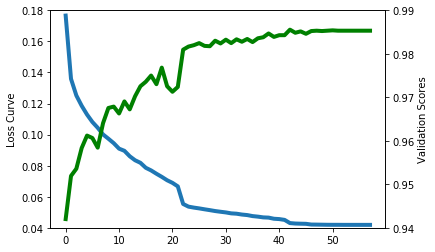

In [29]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(clf.loss_curve_, linewidth=4)
#ax1.set_xlim([0, 60])
ax1.set_ylim([0.04, 0.18])
ax1.set_ylabel('Loss Curve')

ax2 = ax1.twinx()
ax2.plot(clf.validation_scores_, linewidth=4, c='g')
ax2.set_ylim([0.94, 0.99])
ax2.set_ylabel('Validation Scores')

In [22]:
print('Training Results')
y_true1, y_pred1 = y_train, clf.predict(X_train)
print(classification_report(y_true1, y_pred1, digits=4))

print('Test Results')
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, digits=4))

Training Results
             precision    recall  f1-score   support

        100     0.9998    1.0000    0.9999     58583
        200     0.9800    0.9796    0.9798     34253
        500     0.9793    0.9794    0.9793     33206

avg / total     0.9890    0.9890    0.9890    126042

Test Results

             precision    recall  f1-score   support

        100     0.9998    1.0000    0.9999     39312
        200     0.9742    0.9722    0.9732     22881
        500     0.9712    0.9731    0.9722     21835

avg / total     0.9854    0.9854    0.9854     84028



In [31]:
classification_report()

Index([           'Track_ID',               'alpha',               'D_fit',
                  'kurtosis',          'asymmetry1',          'asymmetry2',
                'asymmetry3',                  'AR',          'elongation',
               'boundedness',         'fractal_dim',         'trappedness',
                'efficiency',        'straightness',           'MSD_ratio',
                    'frames',                   'X',                   'Y',
                   'Quality',      'Mean_Intensity',            'SN_Ratio',
                     'Deff1',               'Deff2',          'Mean alpha',
                 'Std alpha',          'Mean D_fit',           'Std D_fit',
             'Mean kurtosis',        'Std kurtosis',     'Mean asymmetry1',
            'Std asymmetry1',     'Mean asymmetry2',      'Std asymmetry2',
           'Mean asymmetry3',      'Std asymmetry3',             'Mean AR',
                    'Std AR',     'Mean elongation',      'Std elongation',
          'M

In [38]:
Deff1 = fstats_sub.Deff1.values

In [41]:
bins = [0, 1.872, 3.858, 10**20]
binned = np.histogram(Deff1, [0, 1.872, 3.858, 10**20])

In [40]:
binned

(array([98542, 25117, 41341]),
 array([0, 1.872, 3.858, 100000000000000000000], dtype=object))

In [65]:
y_pred2 = list(pd.cut(fstats_tot.Deff1.values, bins=[0, 1.872, 3.858, 1000], labels=['500', '200', '100']).astype(str))
y_true2 = fstats_tot['Particle Size'].values

In [66]:
print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        100     0.9777    0.7223    0.8309     97895
        200     0.3095    0.1851    0.2316     57134
        500     0.4886    0.9191    0.6380     55041
        nan     0.0000    0.0000    0.0000         0

avg / total     0.6678    0.6278    0.6174    210070



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [73]:
kb = 1.381*10**-23
T = 303
nu = 0.000797


size2 = 2*10**9*10**12*kb*T/(fstats_tot.Deff1.values*6*np.pi*nu)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [74]:
y_pred2 = list(pd.cut(size2, bins=[-100, 150, 350, 1000000], labels=['100', '200', '500']).astype(str))

In [75]:
print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        100     0.9749    0.7433    0.8434     97895
        200     0.3916    0.2781    0.3252     57134
        500     0.5157    0.8882    0.6525     55041
        nan     0.0000    0.0000    0.0000         0

avg / total     0.6959    0.6547    0.6525    210070



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcab9c153c8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fcab9b65da0>], dtype=object)

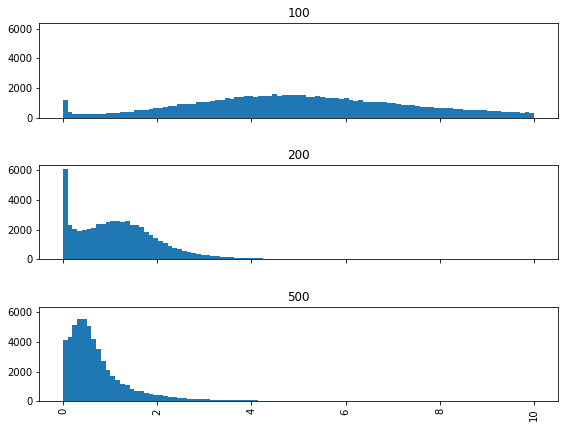

In [96]:
fstats_tot.hist(column='Deff1', by='Particle Size', sharex=True, bins=np.linspace(0, 10, 100),
                figsize=(9, 7), grid=False, layout=(3,1), sharey=True, )

In [4]:
sizes

/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


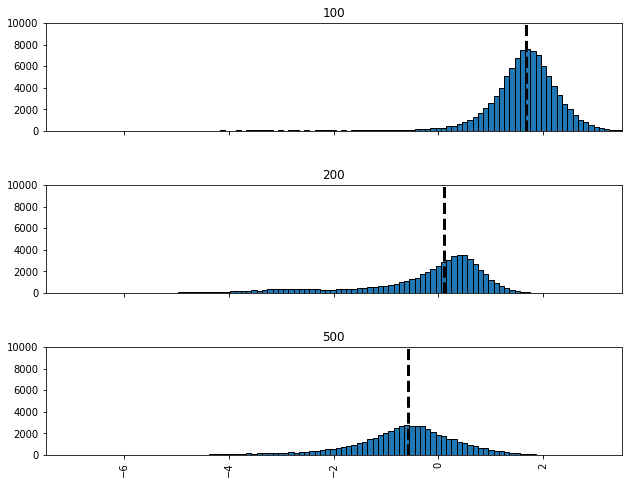

In [12]:
bins = np.linspace(-10, 10, 200)
axes = fstats_tot.hist(column='LogDeff1', by='Particle Size', layout=(3, 1), bins=bins, sharex=True, sharey=True,
                        figsize=(10, 8), edgecolor='k')

means = []
types2 = ['100', '200', '500']
for ax, typ in zip(axes, types2):
    ax.set_ylim([0,10000])
    #ax.set_xscale("log", nonposx='clip')
    ax.set_xlim([-7.5,3.5])
    means.append(fstats_tot[fstats_tot['Particle Size']==typ]['LogDeff1'].median())
    ax.axvline(fstats_tot[fstats_tot['Particle Size']==typ]['LogDeff1'].median(), color='k', linestyle='dashed', linewidth=3)

In [7]:
means

[1.6765970540572321, 0.11314102441714863, -0.5795098191928005]

In [8]:
meanD = np.array(means)
meanD.sort()
Dbins = meanD[0:-1] + np.diff(meanD)/2
print(Dbins)

[-0.2331844   0.89486904]


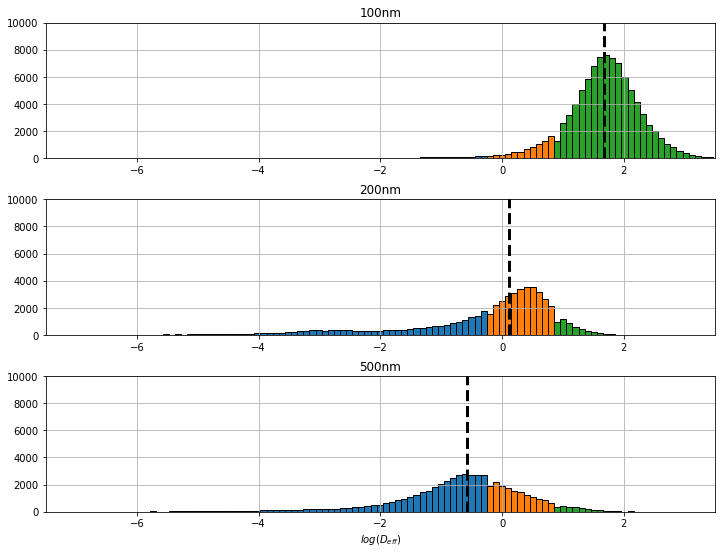

In [30]:
import matplotlib.pyplot as plt
Dbins = [-10, -0.233, 0.895, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=3, figsize=(12, 9))
counter = 0
means = []
for ax in axes:
    means.append(fstats_tot[fstats_tot['Particle Size']==sizes[counter]]['LogDeff1'].median())
    for i in range(3):
        fstats_tot[(fstats_tot['Particle Size']==sizes[counter]) & (Dbins[i] < fstats_tot['LogDeff1']) & (fstats_tot['LogDeff1'] < Dbins[i+1])].hist(column='LogDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-7.5, 3.5])
        ax.set_ylim([0, 10000])
    ax.axvline(fstats_tot[fstats_tot['Particle Size']==sizes[counter]]['LogDeff1'].median(), color='k', linestyle='dashed', linewidth=3)
    ax.set_title(sizes[counter]+ 'nm')
    if counter == 2:
        ax.set_xlabel(r'$log(D_{eff})$')
    counter = counter + 1

In [32]:
y_true2 = fstats_tot['Particle Size'].values
y_pred2 = list(pd.cut(fstats_tot['LogDeff1'].values, bins=Dbins, labels=['500', '200', '100']).astype(str))
print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        100     0.9200    0.8844    0.9019     97895
        200     0.5678    0.5525    0.5600     57134
        500     0.6109    0.6699    0.6390     55041
        nan     0.0000    0.0000    0.0000         0

avg / total     0.7432    0.7379    0.7400    210070



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [48]:
fstats_tot['LogMeanDeff1'] = np.log(fstats_tot['Mean Deff1']).replace([np.inf, -np.inf], np.nan)

In [51]:
meanD = np.array(means)
meanD.sort()
Dbins = meanD[0:-1] + np.diff(meanD)/2
print(Dbins)

[-0.09365521  0.96167416]


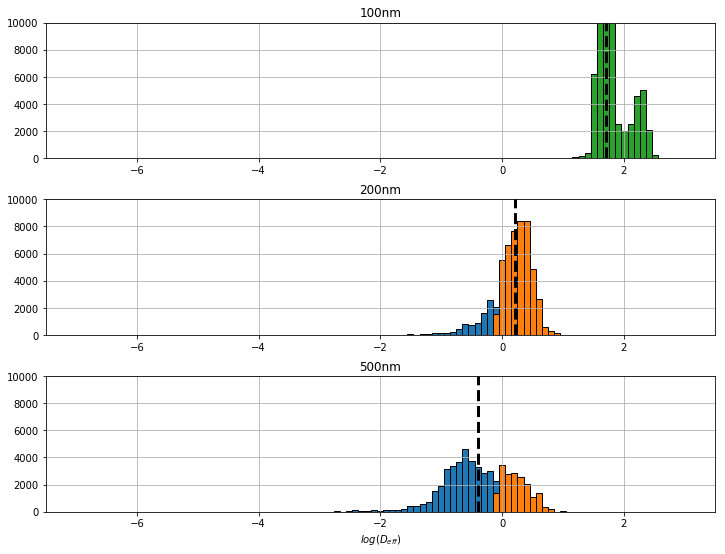

In [52]:
Dbins = [-10, -0.0937, 0.9617, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=3, figsize=(12, 9))
counter = 0
means = []
for ax in axes:
    means.append(fstats_tot[fstats_tot['Particle Size']==sizes[counter]]['LogMeanDeff1'].median())
    for i in range(3):
        fstats_tot[(fstats_tot['Particle Size']==sizes[counter]) & (Dbins[i] < fstats_tot['LogMeanDeff1']) & (fstats_tot['LogMeanDeff1'] < Dbins[i+1])].hist(column='LogMeanDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-7.5, 3.5])
        ax.set_ylim([0, 10000])
    ax.axvline(fstats_tot[fstats_tot['Particle Size']==sizes[counter]]['LogMeanDeff1'].median(), color='k', linestyle='dashed', linewidth=3)
    ax.set_title(sizes[counter]+ 'nm')
    if counter == 2:
        ax.set_xlabel(r'$log(D_{eff})$')
    counter = counter + 1

In [53]:
y_true2 = fstats_tot['Particle Size'].values
y_pred2 = list(pd.cut(fstats_tot['LogMeanDeff1'].values, bins=Dbins, labels=['500', '200', '100']).astype(str))
print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        100     0.9996    1.0000    0.9998     97895
        200     0.7205    0.8176    0.7660     57134
        500     0.7798    0.6698    0.7206     55041
        nan     0.0000    0.0000    0.0000         0

avg / total     0.8661    0.8639    0.8630    210070



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
y_pred2 = list(pd.cut(size2, bins=[-100, 150, 350, 1000000], labels=['100', '200', '500']).astype(str))
print(classification_report(y_true2, y_pred2, digits=4))

In [102]:
size3 = np.random.rand(len(size2))
y_pred2 = list(pd.cut(size3, bins=[0, 0.33333333, 0.666666666, 10], labels=['100', '200', '500']).astype(str))

In [103]:
print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        100     0.4643    0.3322    0.3873     97895
        200     0.2721    0.3324    0.2992     57134
        500     0.2621    0.3344    0.2939     55041

avg / total     0.3590    0.3328    0.3389    210070



In [104]:
size2 = 2*10**9*10**12*kb*T/(fstats_tot['Mean Deff1'].values*6*np.pi*nu)
y_pred2 = list(pd.cut(size2, bins=[-100, 150, 350, 1000000], labels=['100', '200', '500']).astype(str))

In [105]:
print(classification_report(y_true2, y_pred2, digits=4))

             precision    recall  f1-score   support

        100     1.0000    0.9979    0.9989     97895
        200     0.7012    0.1323    0.2226     57134
        500     0.5120    0.9450    0.6642     55041
        nan     0.0000    0.0000    0.0000         0

avg / total     0.7909    0.7486    0.7001    210070



/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [54]:
kb = 1.381*10**-23
T = 303
nu = 0.000797

sizes3 = np.array([150, 350])
Dbins2 = np.log(2*10**9*10**12*kb*T/(sizes3*6*np.pi*nu))
Dbins2.sort()
Dbins2

array([ 0.46475104,  1.3120489 ])

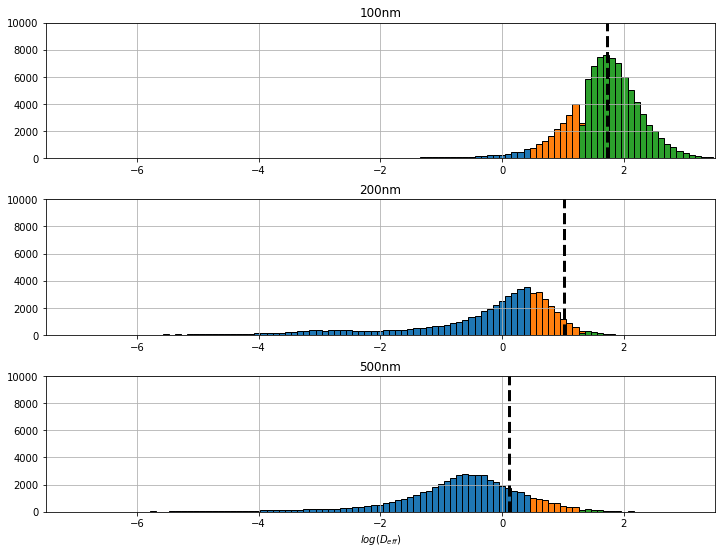

In [46]:
import matplotlib.pyplot as plt
Dbins = [-10, 0.4648, 1.3120, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=3, figsize=(12, 9))
counter = 0
means = []
Ds = np.log(2*10**9*10**12*kb*T/(np.array([100, 200, 500])*6*np.pi*nu))
for ax in axes:
    means.append(fstats_tot[fstats_tot['Particle Size']==sizes[counter]]['LogDeff1'].median())
    for i in range(3):
        fstats_tot[(fstats_tot['Particle Size']==sizes[counter]) & (Dbins[i] < fstats_tot['LogDeff1']) & (fstats_tot['LogDeff1'] < Dbins[i+1])].hist(column='LogDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-7.5, 3.5])
        ax.set_ylim([0, 10000])
    ax.axvline(Ds[counter], color='k', linestyle='dashed', linewidth=3)
    ax.set_title(sizes[counter]+ 'nm')
    if counter == 2:
        ax.set_xlabel(r'$log(D_{eff})$')
    counter = counter + 1

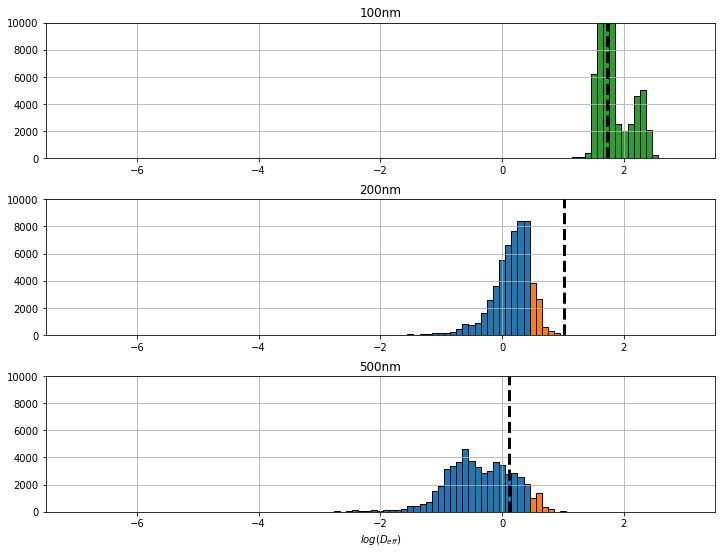

In [55]:
import matplotlib.pyplot as plt
Dbins = [-10, 0.4648, 1.3120, 10]
bins = np.linspace(-10, 10, 200)
fig, axes = plt.subplots(nrows=3, figsize=(12, 9))
counter = 0
means = []
Ds = np.log(2*10**9*10**12*kb*T/(np.array([100, 200, 500])*6*np.pi*nu))
for ax in axes:
    means.append(fstats_tot[fstats_tot['Particle Size']==sizes[counter]]['LogMeanDeff1'].median())
    for i in range(3):
        fstats_tot[(fstats_tot['Particle Size']==sizes[counter]) & (Dbins[i] < fstats_tot['LogMeanDeff1']) & (fstats_tot['LogMeanDeff1'] < Dbins[i+1])].hist(column='LogMeanDeff1', bins=bins, figsize=(12,3), edgecolor='k', ax=ax, )
        ax.set_xlim([-7.5, 3.5])
        ax.set_ylim([0, 10000])
    ax.axvline(Ds[counter], color='k', linestyle='dashed', linewidth=3)
    ax.set_title(sizes[counter]+ 'nm')
    if counter == 2:
        ax.set_xlabel(r'$log(D_{eff})$')
    counter = counter + 1